# Predicting Yelp Star Ratings for Restaraunts based on attributes


## Data cleaning
### Cleaning business data

In [1]:
import json
import numpy as np
import pandas as pd

In [2]:
# load and preview the data
business_data = []
with open('data/business_sample_cleveland.json') as f:
    for line in f:
        business_data.append(json.loads(line))
business_df = pd.DataFrame.from_dict(business_data)
print business_df.head()
print business_df.shape

                    address  \
0  2128 Warrensville Ctr Rd   
1            3710 Payne Ave   
2            13181 Cedar Rd   
3                             
4             1 American Rd   

                                          attributes             business_id  \
0              {u'BusinessAcceptsCreditCards': True}  jqp5TibmgJZVFKHTp3XfqQ   
1  {u'BusinessParking': {u'garage': False, u'stre...  1cLXGXThDYZ5WK_KpBLtkw   
2  {u'BusinessParking': {u'garage': False, u'stre...  Pawavw9U8rjxWVPU-RB7LA   
3                                                 {}  2bGCupC5mfHmEaor4pZaqg   
4  {u'BusinessAcceptsCreditCards': True, u'Restau...  Q7Xw5YbS4wN7sdqZRsq4vQ   

                                          categories       city  \
0             [Car Wash, Automotive, Auto Detailing]  Cleveland   
1                     [Food, Bakeries, Coffee & Tea]  Cleveland   
2                             [Chinese, Restaurants]  Cleveland   
3  [Home Services, Home Cleaning, Local Services,...  Cleveland 

In [3]:
# "name" column name is ambiguous with df.name - change it
business_df = business_df.rename(columns = {'name': 'BusinessName'})

The business categories (e.g. Restaurant, Home Cleaning) are in a list in the 'categories' column, which isn't easy to parse. By one-hot encoding them, we can more easily filter the dataset by category and use the categories as features in a model.

In [4]:
business_df['categories_clean'] = map(lambda x: '|'.join(x), business_df['categories'])
categories_df = business_df.categories_clean.str.get_dummies(sep='|')
# merge
business_df = business_df.merge(categories_df, left_index=True, right_index=True)
# remove intermediate columns (no longer needed)
business_df.drop(['categories', 'categories_clean'], axis=1, inplace=True)
print business_df.shape

(3164, 649)


We also need to one-hot encode the business attributes and their sub-attributes, which are currently in dictionaries in the 'attributes' column.

In [5]:
business_df['attributes'].head()

0                {u'BusinessAcceptsCreditCards': True}
1    {u'BusinessParking': {u'garage': False, u'stre...
2    {u'BusinessParking': {u'garage': False, u'stre...
3                                                   {}
4    {u'BusinessAcceptsCreditCards': True, u'Restau...
Name: attributes, dtype: object

In [6]:
business_df = business_df.join(pd.DataFrame(business_df['attributes'].to_dict()).T)
# further split sub-attributes into their own columns
cols_to_split = ['BusinessParking', 'Ambience', 'BestNights', 'GoodForMeal', 'HairSpecializesIn', 'Music']
for col_to_split in cols_to_split:
    new_df = pd.DataFrame(business_df[col_to_split].to_dict()).T
    new_df.columns = [col_to_split + '_' + str(col) for col in new_df.columns]
    business_df = business_df.join(new_df)

business_df.drop(['attributes'] + cols_to_split, axis=1, inplace=True)

print business_df.head()
print business_df.shape

                    address             business_id       city  \
0  2128 Warrensville Ctr Rd  jqp5TibmgJZVFKHTp3XfqQ  Cleveland   
1            3710 Payne Ave  1cLXGXThDYZ5WK_KpBLtkw  Cleveland   
2            13181 Cedar Rd  Pawavw9U8rjxWVPU-RB7LA  Cleveland   
3                            2bGCupC5mfHmEaor4pZaqg  Cleveland   
4             1 American Rd  Q7Xw5YbS4wN7sdqZRsq4vQ  Cleveland   

                                               hours  is_open   latitude  \
0  {u'Monday': u'8:30-18:00', u'Tuesday': u'8:30-...        1  41.501820   
1  {u'Monday': u'9:00-20:00', u'Friday': u'9:00-2...        1  41.509408   
2  {u'Monday': u'11:30-21:30', u'Tuesday': u'11:3...        1  41.501413   
3  {u'Monday': u'0:00-0:00', u'Tuesday': u'0:00-0...        1  41.376464   
4                                                 {}        1  41.437500   

   longitude                      BusinessName       neighborhood postal_code  \
0 -81.536776            Alpaul Automobile Wash                   

While most of these new columns we just made are boolean attributes, a number of them are categorical, which need some special handling. We need to encode them so models can use them as features.

In [7]:
# columns with non-boolean categorical values:
cols_to_split = ['AgesAllowed', 'Alcohol', 'BYOBCorkage', 'NoiseLevel', 'RestaurantsAttire', 'Smoking', 'WiFi']
new_cat = pd.concat([pd.get_dummies(business_df[col], prefix=col, prefix_sep='_') for col in cols_to_split], axis=1)
# keep all columns (not n-1) because 0's for all of them indicates that the data was missing (useful info)
business_df = pd.concat([business_df, new_cat], axis=1)
business_df.drop(cols_to_split, inplace=True, axis=1)
business_df.head()

,address,business_id,city,hours,is_open,latitude,longitude,BusinessName,neighborhood,postal_code,...,NoiseLevel_very_loud,RestaurantsAttire_casual,RestaurantsAttire_dressy,RestaurantsAttire_formal,Smoking_no,Smoking_outdoor,Smoking_yes,WiFi_free,WiFi_no,WiFi_paid
0,2128 Warrensville Ctr Rd,jqp5TibmgJZVFKHTp3XfqQ,Cleveland,"{u'Monday': u'8:30-18:00', u'Tuesday': u'8:30-...",1,41.501820,-81.536776,Alpaul Automobile Wash,,44121,...,0,0,0,0,0,0,0,0,0,0
1,3710 Payne Ave,1cLXGXThDYZ5WK_KpBLtkw,Cleveland,"{u'Monday': u'9:00-20:00', u'Friday': u'9:00-2...",1,41.509408,-81.662162,Koko Bakery,Goodrich Kirtland,44114,...,0,0,0,0,0,0,0,1,0,0
2,13181 Cedar Rd,Pawavw9U8rjxWVPU-RB7LA,Cleveland,"{u'Monday': u'11:30-21:30', u'Tuesday': u'11:3...",1,41.501413,-81.565982,Richie Chan's Chinese Restaurant,,44118,...,0,1,0,0,0,0,0,0,1,0
3,,2bGCupC5mfHmEaor4pZaqg,Cleveland,"{u'Monday': u'0:00-0:00', u'Tuesday': u'0:00-0...",1,41.376464,-81.767764,Clean Machine,,44130,...,0,0,0,0,0,0,0,0,0,0
4,1 American Rd,Q7Xw5YbS4wN7sdqZRsq4vQ,Cleveland,{},1,41.437500,-81.763626,Cardstore,Brooklyn,44144,...,0,0,0,0,0,0,0,0,0,0


There are a lot of missing values. We can clean the missing values by giving them a value that's not True or False, but right in the middle: 0.5.

In [8]:
# convert true/false columns to 0/.5/1 for false/missing/true
print business_df['BusinessAcceptsCreditCards'].head(10)
print business_df.shape
business_df=business_df[business_df['Restaurants'] == 1]
print business_df.shape
business_df = business_df[business_df.columns[business_df.isnull().mean() < 0.8]]
print business_df.shape
business_df = business_df.fillna(0.5).apply(pd.to_numeric, errors='ignore')  # can narrow with .iloc[:,648:722] if necessary
business_df.head(10)
# business_df['BusinessAcceptsCreditCards'].head(10)

0     True
1     True
2    False
3      NaN
4     True
5     True
6     True
7      NaN
8     True
9     True
Name: BusinessAcceptsCreditCards, dtype: object
(3164, 737)
(1361, 737)
(1361, 703)


,address,business_id,city,hours,is_open,latitude,longitude,BusinessName,neighborhood,postal_code,...,NoiseLevel_very_loud,RestaurantsAttire_casual,RestaurantsAttire_dressy,RestaurantsAttire_formal,Smoking_no,Smoking_outdoor,Smoking_yes,WiFi_free,WiFi_no,WiFi_paid
2,13181 Cedar Rd,Pawavw9U8rjxWVPU-RB7LA,Cleveland,"{u'Monday': u'11:30-21:30', u'Tuesday': u'11:3...",1,41.501413,-81.565982,Richie Chan's Chinese Restaurant,,44118.0,...,0,1,0,0,0,0,0,0,1,0
5,728 Richmond Rd,wkhxaIt6S9bQ0twAD9Svpw,Cleveland,"{u'Monday': u'11:00-21:00', u'Tuesday': u'11:0...",0,41.540814,-81.497677,Giuseppes Pizza & Subs,,44143.0,...,0,0,0,0,0,0,0,0,0,0
9,11625 Euclid Ave,VUb97h3RTg6InKdfgB49Bw,Cleveland,"{u'Monday': u'16:00-0:30', u'Tuesday': u'16:00...",1,41.511107,-81.602625,Happy Dog at the Euclid Tavern,,44106.0,...,0,1,0,0,0,1,0,1,0,0
11,7412 Detroit Ave,CtYWpX_cy1YdZgoKtS0Tqg,Cleveland,"{u'Monday': u'10:00-0:00', u'Tuesday': u'10:00...",1,41.482782,-81.736226,Happys Pizza,Detroit-Shoreway,44102.0,...,1,1,0,0,0,0,0,0,1,0
12,4645 Northfield Rd,n8GCGa5gX17Ibix5VsGMuw,Cleveland,"{u'Monday': u'10:30-23:00', u'Tuesday': u'10:3...",1,41.430684,-81.524946,Popeyes Louisiana Kitchen,,44128.0,...,0,1,0,0,0,0,0,0,0,0
16,1900 Euclid Ave,8FZftD3Y5jQ2R44EDBqhlA,Cleveland,"{u'Monday': u'9:00-19:00', u'Tuesday': u'9:00-...",1,41.501186,-81.677437,Cafe Bon Appetit,Quadrangle,44115.0,...,0,1,0,0,0,0,0,0,1,0
17,24325 Cedar Rd,WpkuAJfHSIgjppRC-Wnxgg,Cleveland,"{u'Monday': u'11:00-22:00', u'Tuesday': u'11:0...",1,41.503160,-81.502326,Brio Tuscan Grille,,44124.0,...,0,1,0,0,0,0,0,0,0,0
19,200 Euclid Ave,YNI26xBkdOzI1TMGmIcEaw,Cleveland,"{u'Monday': u'7:00-2:00', u'Tuesday': u'7:00-2...",1,41.499310,-81.691519,Taco Bell Cantina,Gateway District,44114.0,...,0,1,0,0,0,0,0,1,0,0
20,850 Euclid Ave,MTsIckdo3_uKuqk3B4zuKA,Cleveland,"{u'Monday': u'11:00-16:00', u'Tuesday': u'11:0...",1,41.499778,-81.687028,Cleveland Pickle,Gateway District,44114.0,...,0,1,0,0,0,0,0,0,0,0
25,1838 Coventry Rd,UgWVMUWFrr6bt3NSfuKrGQ,Cleveland Heights,"{u'Monday': u'10:30-1:30', u'Tuesday': u'10:30...",1,41.509222,-81.580223,Guys Pizza Co,,44118.0,...,0,1,0,0,0,0,0,0,1,0


In [9]:
# deal with missing values in postal code
print business_df['postal_code'].isnull().sum()
business_df['postal_code'] = business_df['postal_code'].fillna(0)
print business_df['postal_code'].isnull().sum()

2
0


In [10]:
# check that all nulls are removed
business_df.isnull().sum().sum()

0

### Cleaning check-in data
This data shows, for each business, the number of check-ins for each hour of the day. I didn't use this data for prediction in this project, but I cleaned it to use for future projects.

In [11]:
checkin_data = []
with open('data/checkin_sample_cleveland.json') as f:
    for line in f:
        checkin_data.append(json.loads(line))
checkin_df = pd.DataFrame.from_dict(checkin_data)
checkin_df.head()

,business_id,time
0,Zn3GV2xa9a-8bHjUM-2sow,"{u'Monday': {u'1:00': 1}, u'Thursday': {u'23:0..."
1,lia867Aug7wdfpo5t86W3Q,{u'Friday': {u'0:00': 1}}
2,8U6EmwNaeTnhKbhBgIZPGQ,"{u'Monday': {u'5:00': 1, u'4:00': 3, u'1:00': ..."
3,KsYAGLP4yC7FbfixaeCHsA,"{u'Monday': {u'14:00': 4, u'22:00': 4, u'12:00..."
4,bo3z3-WUNblcRKRrWqeTAg,"{u'Monday': {u'19:00': 10, u'14:00': 3, u'17:0..."


The 'time' column is a dictionary - we need to separate the data for each hour into its own column.

In [12]:
# separate the values from the dict so they're a list of ['Day', 'time', count]
checkin_df['time_clean'] = map(lambda (x, y): map(lambda (k, v): map(lambda(i, value): [k, value, v.values()[i]], enumerate(v)), y.iteritems()), checkin_df['time'].iteritems())
# flatten the list so each day is no longer in its own list
checkin_df['time_clean'] = map(lambda l: [item for sublist in l for item in sublist], checkin_df['time_clean'])
# make it a cleaner dict where key='Day Time', value=count
checkin_df['time_clean'] = map(lambda x: {s + ' ' + t: u for (s, t, u) in x}, checkin_df['time_clean'])
# add column for each day/time with counts as values
new_checkin_df = checkin_df.join(pd.DataFrame(checkin_df["time_clean"].to_dict()).T).fillna(0)
# remove intermediate columns (no longer needed)
new_checkin_df.drop(['time', 'time_clean'], axis=1, inplace=True)
new_checkin_df.head()

,business_id,Friday 0:00,Friday 10:00,Friday 11:00,Friday 12:00,Friday 13:00,Friday 14:00,Friday 15:00,Friday 16:00,Friday 17:00,...,Wednesday 22:00,Wednesday 23:00,Wednesday 2:00,Wednesday 3:00,Wednesday 4:00,Wednesday 5:00,Wednesday 6:00,Wednesday 7:00,Wednesday 8:00,Wednesday 9:00
0,Zn3GV2xa9a-8bHjUM-2sow,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,lia867Aug7wdfpo5t86W3Q,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8U6EmwNaeTnhKbhBgIZPGQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,KsYAGLP4yC7FbfixaeCHsA,4.0,0.0,1.0,0.0,4.0,0.0,3.0,1.0,1.0,...,0.0,0.0,2.0,2.0,1.0,0.0,2.0,0.0,1.0,1.0
4,bo3z3-WUNblcRKRrWqeTAg,5.0,42.0,10.0,1.0,2.0,2.0,4.0,4.0,0.0,...,6.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.0


Merge this new checkin data with business_df.

In [13]:
business_df = business_df.merge(new_checkin_df, left_on='business_id', right_on='business_id', how='left')
business_df.head()

,address,business_id,city,hours,is_open,latitude,longitude,BusinessName,neighborhood,postal_code,...,Wednesday 22:00,Wednesday 23:00,Wednesday 2:00,Wednesday 3:00,Wednesday 4:00,Wednesday 5:00,Wednesday 6:00,Wednesday 7:00,Wednesday 8:00,Wednesday 9:00
0,13181 Cedar Rd,Pawavw9U8rjxWVPU-RB7LA,Cleveland,"{u'Monday': u'11:30-21:30', u'Tuesday': u'11:3...",1,41.501413,-81.565982,Richie Chan's Chinese Restaurant,,44118.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,728 Richmond Rd,wkhxaIt6S9bQ0twAD9Svpw,Cleveland,"{u'Monday': u'11:00-21:00', u'Tuesday': u'11:0...",0,41.540814,-81.497677,Giuseppes Pizza & Subs,,44143.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11625 Euclid Ave,VUb97h3RTg6InKdfgB49Bw,Cleveland,"{u'Monday': u'16:00-0:30', u'Tuesday': u'16:00...",1,41.511107,-81.602625,Happy Dog at the Euclid Tavern,,44106.0,...,2.0,5.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
3,7412 Detroit Ave,CtYWpX_cy1YdZgoKtS0Tqg,Cleveland,"{u'Monday': u'10:00-0:00', u'Tuesday': u'10:00...",1,41.482782,-81.736226,Happys Pizza,Detroit-Shoreway,44102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4645 Northfield Rd,n8GCGa5gX17Ibix5VsGMuw,Cleveland,"{u'Monday': u'10:30-23:00', u'Tuesday': u'10:3...",1,41.430684,-81.524946,Popeyes Louisiana Kitchen,,44128.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


But not all of the businesses had check-in data. I set missing values to 0 if I had no check-in data for them.

In [14]:
business_df.iloc[:, 648:] = business_df.iloc[:, 648:].fillna(0)

Our final business data looks like this:

In [15]:
basic_cols = business_df.columns[:13]
print basic_cols

category_cols = business_df.columns[13:648]
print category_cols

attribute_cols = business_df.columns[648:737]
print attribute_cols

checkin_cols = business_df.columns[737:]
print checkin_cols

attribute_checkin_cols = business_df.columns[648:]
#business_df.info(verbose=True, null_counts=True)

Index([     u'address',  u'business_id',         u'city',        u'hours',
            u'is_open',     u'latitude',    u'longitude', u'BusinessName',
       u'neighborhood',  u'postal_code', u'review_count',        u'stars',
              u'state'],
      dtype='object')
Index([u'Accessories', u'Active Life', u'Acupuncture', u'Adult',
       u'Adult Education', u'Adult Entertainment', u'African',
       u'Air Duct Cleaning', u'Airlines', u'Airport Lounges',
       ...
       u'Wine & Spirits', u'Wine Bars', u'Wine Tasting Room', u'Wine Tours',
       u'Wineries', u'Women's Clothing', u'Wraps', u'Yelp Events', u'Yoga',
       u'Zoos'],
      dtype='object', length=635)
Index([               u'BikeParking', u'BusinessAcceptsCreditCards',
                           u'Caters',                u'GoodForKids',
                            u'HasTV',             u'OutdoorSeating',
              u'RestaurantsDelivery',   u'RestaurantsGoodForGroups',
           u'RestaurantsPriceRange2',    u'Rest

## Exploring the data

Let's start by visualizing where our businesses are, colored by neighborhood:

In [16]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
# from mpl_toolkits.basemap import Basemap
%matplotlib inline

In [18]:
# decide map range based on min and max latitude/longitudes
margin = .01
lat_min = min(business_df['latitude'].values) - margin
lat_max = max(business_df['latitude'].values) + margin
lon_min = min(business_df['longitude'].values) - margin
lon_max = max(business_df['longitude'].values) + margin

# create map
m = Basemap(llcrnrlon=lon_min,
            llcrnrlat=lat_min,
            urcrnrlon=lon_max,
            urcrnrlat=lat_max,
            lat_0=(lat_max - lat_min)/2,
            lon_0=(lon_max - lon_min)/2,
            projection='merc',
            resolution='h',
            area_thresh=10000.)
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='white', lake_color='#46bcec')
lons, lats = m(business_df['longitude'].values, business_df['latitude'].values)

# plot points colored by neighborhood
#col = business_df['neighborhood'].replace({u'': 'b'})
color_labels = business_df['neighborhood'].unique()
rgb_values = sns.color_palette("Set2", len(color_labels))
color_map = dict(zip(color_labels, rgb_values))
m.scatter(lons, lats, marker='o', c=business_df['neighborhood'].map(color_map), zorder=5)
plt.show()

NameError: name 'Basemap' is not defined

What does the distribution of star ratings look like?

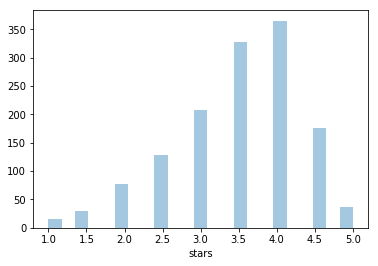

In [19]:
sns.distplot(business_df['stars'], kde=False);

Is a business' star rating affected by whether or not it has, for example, free WiFi? It doesn't seem like it:

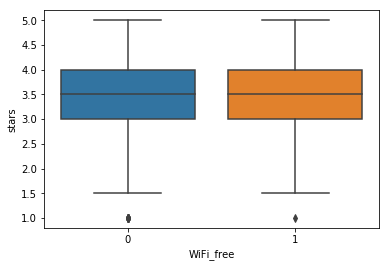

In [20]:
sns.boxplot(x='WiFi_free', y='stars', data=business_df);

Let's look at the average star ratings by category for the highest- and lowest-rated business categories (given that they have at least 5 ratings):

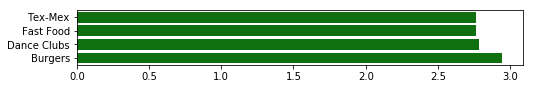

In [21]:
min_ratings = 5
cats = business_df.columns[13:648].values  # category columns
upper_perc = np.percentile(business_df['stars'], 85)
lower_perc = np.percentile(business_df['stars'], 25)
cat_names = []
cat_means = []
for cat in cats:
    if business_df[business_df[cat] == 1].stars.value_counts().sum() >= min_ratings:
        curr_mean = business_df[business_df[cat] == 1].stars.mean()
        if curr_mean >= upper_perc or curr_mean <= lower_perc:
            cat_names.append(cat)
            cat_means.append(business_df[business_df[cat] == 1].stars.mean())

# plot without sorting
#ax = sns.barplot(x=cat_means, y=cats[:how_many], color='g')

# sort by least to most stars
yx = zip(cat_means, cat_names)
yx.sort()
y_sorted, x_sorted = zip(*yx)

fig, ax = plt.subplots()
fig.set_size_inches(8, len(cat_means)/4)
ax = sns.barplot(x=y_sorted, y=x_sorted, color='g')

Let's get some idea of the distribution of ratings for each category:

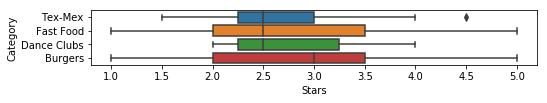

In [22]:
boxplot_df = pd.DataFrame([])
for i, cat in enumerate(cats):
    currgroup = business_df[business_df[cat] == 1]
    if currgroup.stars.value_counts().sum() >= min_ratings:
        if currgroup.stars.mean() >= upper_perc or currgroup.stars.mean() <= lower_perc:
            stars_df = pd.DataFrame([])
            stars_df['Stars'] = currgroup.stars
            stars_df['Category'] = currgroup[cat].name
            stars_df['Mean'] = currgroup.stars.mean()
            boxplot_df = pd.concat([boxplot_df, stars_df])

boxplot_df = boxplot_df.sort_values(['Mean']).reset_index(drop=True)

fig, ax = plt.subplots()
fig.set_size_inches(8, boxplot_df['Category'].nunique()/4)
ax = sns.boxplot(x='Stars', y='Category', data=boxplot_df)

Which business attributes correlate most with a business' star rating? There are too many attributes to show the matrix for all of them, but below you can see that bike parking seems to be slightly correlated with star rating.

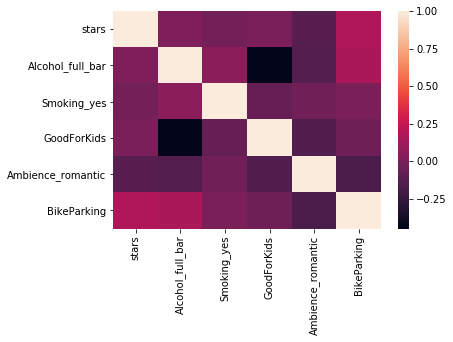

In [23]:
corr_df = business_df[['stars', 'Alcohol_full_bar', 'Smoking_yes', 'GoodForKids', 'Ambience_romantic', 'BikeParking']]
sns.heatmap(corr_df.corr());

## Predictive Modeling

What business attributes predict good ratings? It's probably a different set of attributes for each type of business, so let's choose one business category to work with for now (the one with the most data).

In [24]:
# find the most represented categories
business_df.iloc[:, 13:648].sum().sort_values(ascending=False).head(10)

Restaurants               1361
Nightlife                  284
Bars                       274
Food                       244
American (Traditional)     226
American (New)             185
Sandwiches                 182
Pizza                      171
Fast Food                  131
Burgers                    124
dtype: int64

So we'll try to predict which attributes correlate with restaurants' star ratings. This is a regression problem. Let's start with the simplest model, linear regression.

### Linear regression

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [26]:
# just look at one business category
select_df = business_df[business_df['Restaurants'] == 1]
# just look at attribute columns
model_df = select_df[attribute_cols]  # use just attributes not basic data or check-in columns
model_df['is_open'] = business_df['is_open']  # add one basic data column; not sure why this causes error

feature_cols = model_df.columns
X = model_df
y = select_df.stars

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=1)
print X_train.shape
print X_test.shape

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_train = lr.predict(X_train)
print 'Train RMSE:'
print np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))

y_pred_test = lr.predict(X_test)
print 'Test RMSE:'
print np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))
print ''
print lr.intercept_
res = pd.DataFrame({'feature': feature_cols, 'coef': lr.coef_})
print res.sort_values(by=['coef'], ascending=False)

(1224, 90)
(137, 90)
Train RMSE:
0.7333680580907276
Test RMSE:
0.7725939547357484

3.834499082633869
        coef                     feature
22  0.363431           Ambience_intimate
2   0.331981                      Caters
51  0.329419                 Smoking_yes
40  0.280557     BYOBCorkage_yes_corkage
0   0.238982                 BikeParking
47  0.190356    RestaurantsAttire_dressy
15  0.173761      BusinessParking_street
36  0.146510       Alcohol_beer_and_wine
23  0.139662           Ambience_romantic
20  0.137730              Ambience_divey
32  0.123594           GoodForMeal_lunch
49  0.121256                  Smoking_no
25  0.104340             Ambience_trendy
28  0.082386          GoodForMeal_brunch
75  0.066438                 Friday 6:00
50  0.056898             Smoking_outdoor
80  0.054597                Monday 10:00
5   0.050911              OutdoorSeating
44  0.048827            NoiseLevel_quiet
21  0.046226            Ambience_hipster
39  0.046092              BYOBCorkage_

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Now let's use cross-validation instead of train-test split for a better estimation of the RMSE:

In [27]:
from sklearn.model_selection import KFold, cross_val_score

In [28]:
# just look at one business category
select_df = business_df[business_df['Restaurants'] == 1]
# just look at attribute columns
model_df = select_df[attribute_cols]  # use just attributes not basic data or check-in columns
model_df['is_open'] = business_df['is_open']  # add one basic data column; not sure why this causes error

feature_cols = model_df.columns
X = model_df
y = select_df.stars

lr = LinearRegression()
kfold = KFold(n_splits=10, shuffle=True, random_state=1)
cross_val_scores = cross_val_score(lr, X, y, scoring='neg_mean_squared_error', cv=kfold)
print '10-fold RMSEs:'
print [np.sqrt(-x) for x in cross_val_scores]
print 'CV RMSE:'
print np.sqrt(-np.mean(cross_val_scores))  # RMSE is the sqrt of the avg of MSEs
print 'Std of CV RMSE:'
print np.std(cross_val_scores)

10-fold RMSEs:
[0.7725939547357488, 0.838453617121416, 0.8124507932531825, 0.7776442412503342, 0.75472490769554, 0.8310252873985758, 0.6999671192699825, 0.7313567733914064, 0.7654240440355323, 0.770702456755632]
CV RMSE:
0.7765061751872392
Std of CV RMSE:
0.06315216657086412


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Would it improve the model to add polynomial features? NO IT'S A DISASTER

In [29]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_predict

In [30]:
pf = PolynomialFeatures(degree=2,interaction_only=True)
X_pf = pf.fit_transform(X)  # only apply to attribute columns
print X.shape
print X_pf.shape

lr2 = LinearRegression()
kfold = KFold(n_splits=10, shuffle=True, random_state=1)
pf_cross_val_scores = cross_val_score(lr2, X_pf, y, scoring='neg_mean_squared_error', cv=kfold)

pf_cross_val_predicts = cross_val_predict(lr2, X_pf, y, cv=kfold)
print pf_cross_val_predicts[:20]

print '10-fold RMSEs:'
print [np.sqrt(-x) for x in pf_cross_val_scores]
print 'CV RMSE:'
print np.sqrt(-np.mean(pf_cross_val_scores))  # RMSE is the sqrt of the avg of MSEs
print 'Std of CV RMSE:'
print np.std(pf_cross_val_scores)

(1361, 90)
(1361, 4096)
[-2.12211428e+09 -3.21760397e+08  1.01331075e+09  3.98463394e+07
  4.42727705e+05 -5.57891624e+08 -7.89609720e+07  3.63403880e+07
 -3.59473471e+09  2.76016810e+07  2.60702532e+09  2.51956083e+08
  6.55492934e+08 -8.21291861e+07 -3.10241329e+10  3.30935800e+07
  2.34629987e+09  3.91049742e+08 -9.58458461e+07 -9.32102025e+08]
10-fold RMSEs:
[22774702239.34447, 1676760670.898416, 5626204125.789233, 10597051648.443043, 3331127929.621622, 5770402331.407884, 694213851.1369182, 3114699091.418643, 3612821726.209397, 3965217464.29194]
CV RMSE:
8653340019.660643
Std of CV RMSE:
1.5110595260392627e+20


Could this have happened because of overfitting? Let's see if regularization will help. We can use ridge regularization to prevent overfitting.

In [31]:
from sklearn.linear_model import RidgeCV

In [32]:
ridge = RidgeCV(store_cv_values=True)
ridge.fit(X, y)

ridge_MSEs = ridge.cv_values_
print 'Ridge CV RMSE:'
print np.sqrt(np.mean(ridge_MSEs))

# try on expanded polynomial features
ridge_pf = RidgeCV(store_cv_values=True)
ridge_pf.fit(X_pf, y)

ridge_pf_MSEs = ridge_pf.cv_values_
print 'Ridge PF CV RMSE:'
print np.sqrt(np.mean(ridge_pf_MSEs))

Ridge CV RMSE:
0.771575378407307
Ridge PF CV RMSE:
12.721777922383787


### Decision tree regressor

We can also see if a decision tree regressor does better at predicting restaurants' star ratings from their business attributes.

In [33]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.externals.six import StringIO
from IPython.display import Image
import pydotplus
from sklearn.tree import export_graphviz

In [34]:
# use business attributes to predict star rating, same as above
rg_X_train, rg_X_test, rg_y_train, rg_y_test = train_test_split(X, y, test_size=.2, random_state=1)
features = [x.encode('utf-8') for x in model_df.columns.values]

rg = DecisionTreeRegressor(max_depth=3)
rg.fit(rg_X_train, rg_y_train)
print 'RMSE:'
print np.sqrt(metrics.mean_squared_error(rg_y_test, rg.predict(rg_X_test)))
print ''

# visualize the tree
dot_data = StringIO()  
export_graphviz(rg, out_file=dot_data,  
                    feature_names=features,  
                    filled=True, rounded=True,  
                    special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())

RMSE:
0.8157946414198276



In [35]:
# most important features of the decision tree regressor
pd.DataFrame({'feature': model_df.columns.values, 'importance': rg.feature_importances_}).sort_values(by='importance', ascending=False).head()

,feature,importance
0,BikeParking,0.462113
2,Caters,0.165402
1,BusinessAcceptsCreditCards,0.127218
43,NoiseLevel_loud,0.078610
15,BusinessParking_street,0.065662


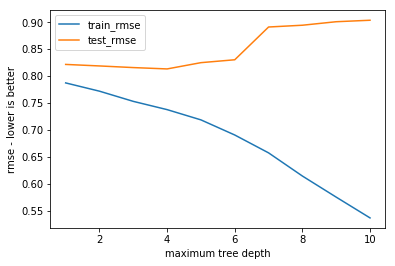

In [36]:
depths = range(1,11)
train_rmse, test_rmse = [],[]
for depth in depths:
    decision_tree = DecisionTreeRegressor(max_depth=depth, random_state=1)
    decision_tree.fit(rg_X_train, rg_y_train)
    curr_train_rmse = np.sqrt(metrics.mean_squared_error(rg_y_train, decision_tree.predict(rg_X_train)))
    curr_test_rmse = np.sqrt(metrics.mean_squared_error(rg_y_test, decision_tree.predict(rg_X_test)))
    train_rmse.append(curr_train_rmse)
    test_rmse.append(curr_test_rmse)
sns.mpl.pyplot.plot(depths,train_rmse,label='train_rmse')
sns.mpl.pyplot.plot(depths,test_rmse,label='test_rmse')
sns.mpl.pyplot.xlabel("maximum tree depth")
sns.mpl.pyplot.ylabel("rmse - lower is better")
sns.mpl.pyplot.legend();

Now let's try it with cross-validation instead of train-test split for a better estimation of the RMSE:

In [37]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.externals.six import StringIO
from IPython.display import Image
import pydotplus
from sklearn.tree import export_graphviz

In [38]:
# use business attributes to predict star rating, same as above
feature_cols = [x.encode('utf-8') for x in model_df.columns.values]
X = model_df
y = select_df.stars

rg = DecisionTreeRegressor(max_depth=3, max_features=10)
kfold = KFold(n_splits=10, shuffle=True, random_state=1)
cross_val_scores = cross_val_score(rg, X, y, scoring='neg_mean_squared_error', cv=kfold)
print '10-fold RMSEs:'
print [np.sqrt(-x) for x in cross_val_scores]
print 'CV RMSE:'
print np.sqrt(-np.mean(cross_val_scores))  # RMSE is the sqrt of the avg of MSEs
print 'Std of CV RMSE:'
print np.std(cross_val_scores)

# visualize the tree
rg.fit(X, y)
dot_data = StringIO()
export_graphviz(rg, out_file=dot_data,  
                    feature_names=feature_cols,  
                    filled=True, rounded=True,  
                    special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())

10-fold RMSEs:
[0.7756325154553833, 0.8434800787632417, 0.9095965150333384, 0.7994874985936695, 0.7444241362263913, 0.8230611152769288, 0.743793124440679, 0.7556963650190871, 0.7774041952859967, 0.7890040956271194]
CV RMSE:
0.7976463734500824
Std of CV RMSE:
0.08010575751366662


This isn't better (lower) than our linear regression RMSE of 0.77 or the ridge RMSE of 0.76. Can we improve it by optimizing the parameters of the decision tree regressor model?

In [39]:
from sklearn.model_selection import GridSearchCV

Best RMSE and parameters:
0.7827575112286399 {'max_features': 0.6, 'max_depth': 3}


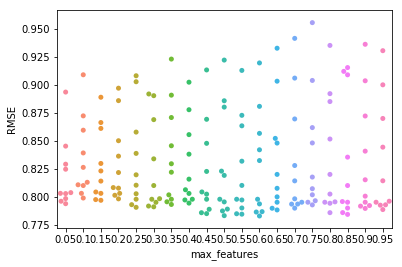

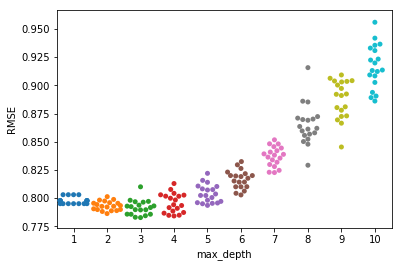

In [40]:
# grid search to find best parameters
rg_grid = DecisionTreeRegressor(random_state=1)
max_depth_range = range(1, 11)
max_features_range = [x/20.0 for x in range(1, 20)]
param_grid = dict(max_depth=max_depth_range, max_features=max_features_range)
kfold = KFold(n_splits=10, shuffle=True, random_state=1)
grid = GridSearchCV(rg_grid, param_grid, cv=kfold, scoring='neg_mean_squared_error')
grid.fit(X, y)
#print grid.cv_results_['mean_test_score']
tree_model = grid.best_estimator_
print 'Best RMSE and parameters:'
print np.sqrt(-grid.best_score_), grid.best_params_
#for mean, param in zip(grid.cv_results_['mean_test_score'], grid.cv_results_['params']):
#    print mean, param

scores = np.sqrt([-x for x in grid.cv_results_['mean_test_score']])  # convert to RMSE
max_f = [x.values()[0] for x in grid.cv_results_['params']]
max_d = [x.values()[1] for x in grid.cv_results_['params']]

rg_grid_results = pd.DataFrame({'RMSE': scores,
                                'max_features': max_f,
                                'max_depth': max_d})

# plot the results
sns.swarmplot(x='max_features', y='RMSE', data=rg_grid_results)
plt.show()
f2 = sns.swarmplot(x='max_depth', y='RMSE', data=rg_grid_results)
plt.show()

Let's put it all together and see which models work the best at predicting star rating from business attributes.

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.svm import SVC

  models      RMSE
2    SVR  0.774289
{'normalize': False}
0.7765033079041284
{'max_features': 0.5, 'max_depth': 4}
0.7852749912174567
{'C': 1.0, 'gamma': 0.01}
0.7742892719936597


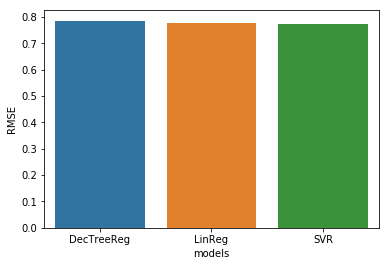

In [42]:
# GridSearch to see if optimizing the parameters will improve (lower) the RMSE
reg_models = [('LinReg', LinearRegression(), {'normalize': [True, False]}),
              ('DecTreeReg', DecisionTreeRegressor(), {'max_depth': range(2, 10, 2), 'max_features': [0.25, 0.5, 0.75, 1.0]}),
              ('SVR', SVR(), {'C': [1e0, 1e1, 1e2, 1e3], 'gamma': np.logspace(-2, 2, 5)})]

names = []
params = []
results = []
for name, model, param in reg_models:
    kfold = KFold(n_splits=10, shuffle=True, random_state=1)
    reg_grid = GridSearchCV(model, param, cv=kfold, scoring='neg_mean_squared_error')
    reg_grid.fit(X, y)
    # just keep the results using the best parameters
    best_model = reg_grid.best_estimator_
    names.append(name)
    params.append(reg_grid.best_params_)
    results.append(np.sqrt(-reg_grid.best_score_))  # convert to RMSE

result_df = pd.DataFrame({'models': names, 'results': results})
result_df.columns = ['models', 'RMSE']
result_df.sort_values(by='RMSE', ascending=False, inplace=True)
print result_df.tail(1)

# plot results
sns.barplot(x='models', y='RMSE', data=result_df);
for i in [0,1,2]:
    print params[i]
    print results[i]

It looks like the best regression model for predicting a restaurant's star rating using its business attributes is support vector regression, with a root mean squared error of 0.76 stars.

In [43]:
#Classification Models
names = []
params = []
results = []
from sklearn.neighbors import KNeighborsClassifier

In [44]:
#Logistic Regression
logreg = LogisticRegression()
y_new= [round(x) for x in y]
#model to train 66% and test 33%
X_train, X_test, y_train, y_test = train_test_split(X, y_new, test_size=0.33, random_state=42)
# fit the model with data
logreg.fit(X_train, y_train)
from sklearn import metrics
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
gd_sr = GridSearchCV(estimator=logreg,  
                     param_grid=grid,
                     scoring='accuracy',
                     cv=2,
                     n_jobs=-1)
gd_sr.fit(X,y_new)
results.append(100*gd_sr.best_score_)
params.append(gd_sr.best_params_)
names.append('logReg')
print results[0]
print params[0]

Accuracy of logistic regression classifier on test set: 0.47
50.91844232182219
{'penalty': 'l2', 'C': 0.001}


In [45]:
#SVC
grid_param = {'C': [6,10,12], 
          'kernel': ['linear','rbf']}
from sklearn.svm import SVC
clf3 = SVC()
gd_sr = GridSearchCV(estimator=clf3,  
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=2,
                     n_jobs=-1)
gd_sr.fit(X,y_new)
results.append(100*gd_sr.best_score_)
params.append(gd_sr.best_params_)
names.append('SVC')
print results[1]
print params[1]

48.05290227773696
{'kernel': 'rbf', 'C': 6}


In [46]:
#KNN
grid_param = {'n_neighbors':[1,2,3],
          'leaf_size':[2,5],
          'weights':['uniform', 'distance'],
          'algorithm':['auto', 'ball_tree','kd_tree','brute'],
          'n_jobs':[-1]}
from sklearn.neighbors import KNeighborsClassifier
clf1 = KNeighborsClassifier(n_neighbors=3,algorithm='ball_tree')
gd_sr = GridSearchCV(estimator=clf1,  
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=2,
                     n_jobs=-1)
gd_sr.fit(X,y_new)
results.append(100*gd_sr.best_score_)
params.append(gd_sr.best_params_)
names.append('KNN')
print results[2]
print params[2]

/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


39.67670830271859
{'n_neighbors': 3, 'n_jobs': -1, 'weights': 'distance', 'leaf_size': 2, 'algorithm': 'ball_tree'}


   models   accuracy
0  logReg  50.918442


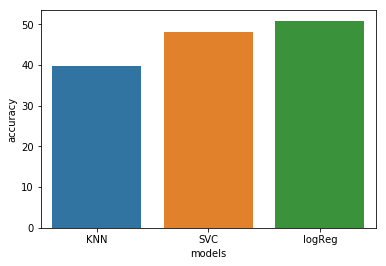

In [47]:
# GridSearch to see if optimizing the parameters will improve (lower) the RMSE

result_df = pd.DataFrame({'models': names, 'results': results})
result_df.columns = ['models', 'accuracy']
result_df.sort_values(by='accuracy', ascending=True, inplace=True)
print result_df.tail(1)

# plot results
sns.barplot(x='models', y='accuracy', data=result_df);